# PyTorch Computer Vision

## 0. Computer Vision libraries in PyTorch

* `torchvision` - the base computer vision library in PyTorch
* `torchvision.datasets` - contains popular datasets like MNIST, CIFAR10, etc.
* `torchvision.models` - contains popular models like ResNet, VGG, etc.
* `torchvision.transforms` - contains popular image transformations like `Compose`, `ToTensor`, etc.
* `torchvision.utils` - contains utility functions like `make_grid`, etc.
* `torchvision.utils.data.Dataset` - the base class for all datasets in PyTorch
* `torchvision.utils.data.DataLoader` - the base class for all data loaders in PyTorch

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.4.0
0.19.0


### 1. Getting a dataset

We'll use FashionMNIST dataset for this tutorial. It contains 60,000 grayscale images of 28x28 pixels each, with 10 classes. We'll use the `torchvision.datasets.FashionMNIST` class to get the dataset.

In [2]:
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, target = train_data[0]
print(image.shape, target)
print(train_data.classes)
print(train_data.class_to_idx)

torch.Size([1, 28, 28]) 9
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


## 1.2 Visualizing the dataset

Image shape: torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

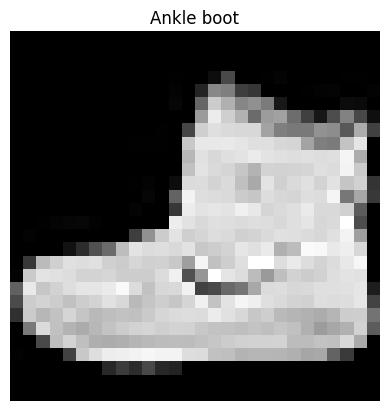

In [5]:
import matplotlib.pyplot as plt
image, target = train_data[0]
print(f"Image shape: {image.shape}") 
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[target]) 
plt.axis("off")  

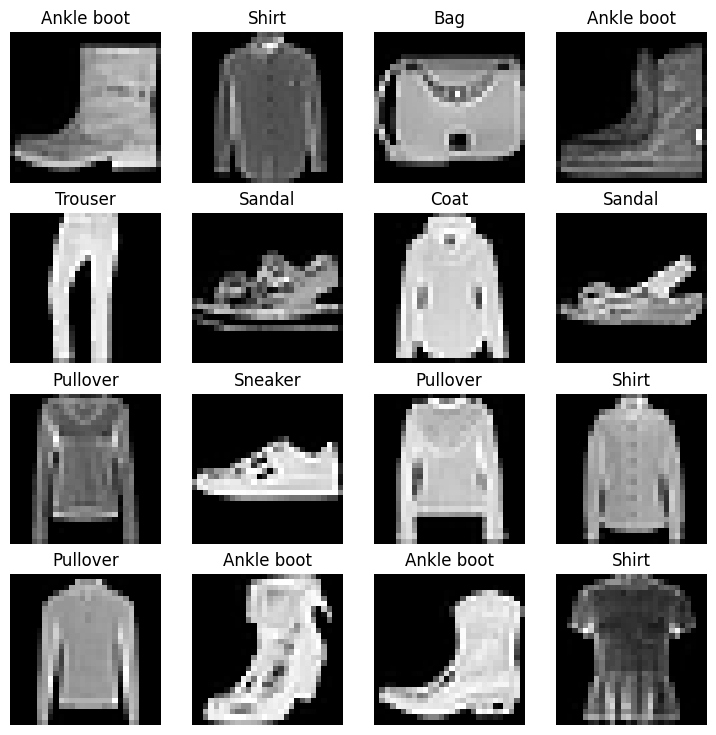

In [6]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    index = torch.randint(len(train_data), size=(1,)).item()
    image, target = train_data[index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(train_data.classes[target])
    plt.axis("off")

### 2. Prepare DataLoader

Right now our data is in the form of PyTorch datasets.
DataLoader turns our dataset into a Python iterable. We can then use this iterable to train our model.

More specifically we want to turn the data into mini-batches. This is because we can't pass the entire dataset into our model at once. It's too large. So we divide the dataset into mini-batches.

1. It is more computationally efficient to pass mini-batches into the model.
2. It gives our neural network more chances to learn. If we pass the entire dataset into the model at once, the model will only learn from that one batch. If we pass in mini-batches, the model will learn from each mini-batch.

See Andrew Ng talk: https://www.youtube.com/watch?v=yFPLyDwVifc

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Create DataLoader for training and test data
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# Check the DataLoader
for images, labels in train_dataloader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    break

Image batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


In [8]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images each")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images each")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x155f49d50>, <torch.utils.data.dataloader.DataLoader object at 0x1561519d0>)
Length of train dataloader: 1875 batches of 32 images each
Length of test dataloader: 313 batches of 32 images each


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 4


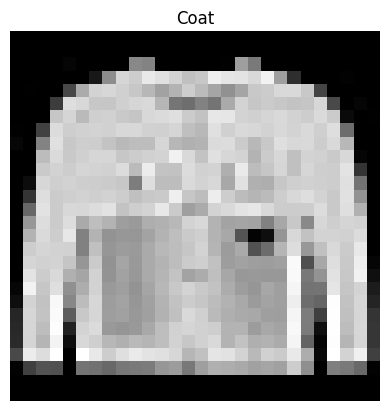

In [10]:
# Show sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), (1,)).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label.item()])
plt.axis("off")
print(f"Image size: {img.shape}")
print(f"Label: {label}")

## 3. Model 0: Building a baselien model

When starting to starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model

In other words, start simply and add complexity as needed.

In [11]:
# Create a flatten layer

flatten_layer = nn.Flatten()

# Get a single sample from the data
x = train_features_batch[0]

# Flatten the sample
output = flatten_layer(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [12]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda")
    print ("CUDA device found.")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
else:
    print ("MPS device not found.")

device

MPS device found.


device(type='mps')

In [13]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super(FashionMNISTModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [14]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_size=28*28, hidden_size=10, num_classes=len(train_data.classes)).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [15]:
# Just checking if the model works
dummy_x = torch.rand([1, 1, 28, 28]).to(device)
r = model_0(dummy_x)
r, r.shape, r.size(1), r.device, r.type()

(tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
          -0.1004,  0.0157]], device='mps:0', grad_fn=<LinearBackward0>),
 torch.Size([1, 10]),
 10,
 device(type='mps', index=0),
 'torch.mps.FloatTensor')

### 3.1. Model 0: Hyperparameters loss, optimizer, evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss`
* Optimizer - our optimizer will be `torch.optim.SGD` (stoachastic gradient descent)
* Evaluation metric - we'll use accuracy as our evaluation metric

In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [17]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

## 3.2 Creating a function to time our experiments

Two things you will often want to track are:
1. Model's performance (loss, accuracy)
1. How fast it runs

In [18]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):  
    print(f"Time to train on {device}: {(end - start):.3f} seconds")
    return end - start

In [19]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

Time to train on cpu: 0.000 seconds


1.0540999937802553e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
1. Loop through training batches, perform training steps, calculate train loss **per batch**
1. Loop through testing batches, calculate testing loss **per batch**
1. print what is happening
1. Time it all
1. 

In [20]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_strat_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device)

        model_0.train()

        # Make predictions, forward pass
        pred = model_0(X).to(device)

        # Calculate loss
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update model
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
            # print(f"Batch {batch} loss: {loss.item()}")

    # Divide total train loss by length of train dataloader to get average train loss
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0., 0.
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:

            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Forward pass
            test_pred = model_0(X_test).to(device)

            # Calculate loss
            test_loss += loss_fn(test_pred, y_test).item()

            # Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # argmax to convert probabilities to class labels

        # Test loss & acc average per batch
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # Print out whats happening
    print(f"\nTrain loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}")

# Calculate total training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_strat_on_cpu, train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.5904, test loss: 0.5095, test accuracy: 82.0387
Epoch 2
-------------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.4763, test loss: 0.4799, test accuracy: 83.1969
Epoch 3
-------------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.4550, test loss: 0.4766, test accuracy: 83.4265
Time to train on mps:0: 25.218 seconds


## 4. Make predictions and get Model 0 results

In [21]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
    """Return a dictionary containing the results of model prediction on data_loader."""
    loss, acc = 0., 0.
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Move data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X).to(device)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # argmax to convert probabilities to class labels

        # Scale loss and acc to average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss, # .item(),
        "model_acc": acc,
        }

model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663889130273945,
 'model_acc': 83.42651757188499}

# 6. Model 1: Building a better model with non-linearity (ReLU)

In [22]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 num_classes: int):
        super(FashionMNISTModelV1, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, 
                      out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, 
                      out_features=num_classes),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)
    


In [23]:
# Create an instance of the model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_size=28*28, hidden_size=10, num_classes=len(train_data.classes)).to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

### 6.1 Setup loss, optimizer and evaluation metric

In [24]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

### 6.2 Functionizing a training/test loop and training a model on batches of data

1. Loop through epochs
1. Loop through training batches, perform training steps, calculate train loss **per batch**
1. Loop through testing batches, calculate testing loss **per batch**
1. print what is happening
1. Time it all
1. 

In [25]:

def train_step(model: nn.Module, 
               dataloader: DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn, 
               device: torch.device = device) -> tuple[float, float]:
    train_loss, train_acc = 0, 0

    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Make predictions, forward pass
        pred = model(X)

        # Calculate loss
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=pred.argmax(dim=1)) # argmax to convert probabilities to class labels

        # Zero the gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update model
        optimizer.step()

        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)} / {len(dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader to get average train loss
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


In [26]:

def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device) -> tuple[float, float]:
    test_loss, test_acc = 0., 0.
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            # Forward pass
            test_pred = model(X_test)

            # Calculate loss
            test_loss += loss_fn(test_pred, y_test).item()

            # Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # argmax to convert probabilities to class labels

        # Test loss & acc average per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc


In [27]:

from tqdm.auto import tqdm


torch.manual_seed(42)
train_time_strat_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    ### Training
    train_loss, train_acc = train_step(model=model_1, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    print(f"\nTrain loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")

    ### Testing
    test_loss, test_acc = test_step(model=model_1, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

    # Print out whats happening
    print(f"Test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}%")

# Calculate total training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_strat_on_gpu, train_time_end_on_gpu, device=str(next(model_1.parameters()).device))    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------

Train loss: 1.0920, Train accuracy: 61.34%
Test loss: 0.95637, test accuracy: 65.00%
Epoch 2
-------------------------------

Train loss: 0.7810, Train accuracy: 71.94%
Test loss: 0.72611, test accuracy: 73.99%
Epoch 3
-------------------------------

Train loss: 0.6704, Train accuracy: 75.94%
Test loss: 0.69007, test accuracy: 74.81%
Time to train on mps:0: 22.458 seconds


In [28]:
# Linear only on CPU & Non-linear on GPU
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_0_results, model_1_results

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.47663889130273945,
  'model_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.690065766104494,
  'model_acc': 74.810303514377})

## Model 2: Building a CNN model

- See explainer of CNN at https://poloclub.github.io/cnn-explainer/
- 

In [29]:
class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN Explainer website"""
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 num_classes: int):
        super(FashionMNISTModelV2, self).__init__()
        self.conv_blocks_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_blocks_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size * 7 * 7, out_features=num_classes),
            # nn.Linear(in_features=hidden_size * (62 / 4 * 62 / 4), out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks_1(x)
        x = self.conv_blocks_2(x)
        x = self.classifier(x)
        return x

In [30]:
len(train_data.classes)

10

In [31]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_size=1, hidden_size=10, num_classes=len(train_data.classes)).to(device)

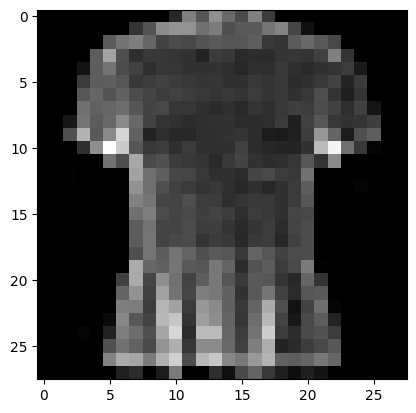

In [32]:
plt.imshow(image.squeeze(), cmap="gray")

In [33]:
model_2(image.to(device).unsqueeze(0))

tensor([[ 0.0300, -0.0610,  0.0485, -0.0278, -0.0125,  0.0172, -0.0056, -0.0121,
          0.0243,  0.0095]], device='mps:0', grad_fn=<LinearBackward0>)

In [34]:
rand_image_tensor = torch.rand([1, 28, 28]).to(device)
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [35]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [36]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='mps:0', grad_fn=<LinearBackward0>)

In [37]:
model_2.state_dict()

OrderedDict([('conv_blocks_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
     

### 7.1 Stepping through `nn.Conv2d`

In [38]:
torch.manual_seed(42)

images = torch.rand(32, 3, 64, 64) # Example of batch of 32 images with 3 channels and 64x64 pixels
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Test image shape: {test_image.shape}")
print(f"Test image:]n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Test image shape: torch.Size([3, 64, 64])
Test image:]n tensor([[[0.8823, 0.9150, 0.3829,  ..., 0.1587, 0.6542, 0.3278],
         [0.6532, 0.3958, 0.9147,  ..., 0.2083, 0.3289, 0.1054],
         [0.9192, 0.4008, 0.9302,  ..., 0.5535, 0.4117, 0.3510],
         ...,
         [0.1457, 0.1499, 0.3298,  ..., 0.9624, 0.6400, 0.7409],
         [0.1709, 0.5797, 0.6340,  ..., 0.6885, 0.2405, 0.5956],
         [0.9199, 0.1247, 0.3573,  ..., 0.6752, 0.2058, 0.5027]],

        [[0.1458, 0.9024, 0.9217,  ..., 0.1868, 0.6352, 0.8431],
         [0.9549, 0.4435, 0.6924,  ..., 0.1168, 0.7160, 0.5462],
         [0.1616, 0.1054, 0.8614,  ..., 0.4531, 0.4736, 0.9448],
         ...,
         [0.4309, 0.3986, 0.1907,  ..., 0.9444, 0.2848, 0.3776],
         [0.7948, 0.6855, 0.1009,  ..., 0.6147, 0.7747, 0.2323],
         [0.5840, 0.9795, 0.3277,  ..., 0.3549, 0.1263, 0.1280]],

        [[0.5027, 0.4195, 0.8893,  ..., 0.3084, 0.1567, 0.7860],
         [0.7310, 0.

In [39]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [40]:
# Create a single convolutional layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d`

In [41]:
# Print out original shape without unsqueeze
print(f"Original test image shape: {test_image.shape}")
print(f"Test image shape after unsqueeze: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after groing through Conv Layer: {test_image_through_conv.shape}")

print(f"Shape after groing through MaxPool2d: {max_pool_layer(test_image_through_conv).shape}")

# print(f"Convolutional layer: {test_image_through_conv}")

Original test image shape: torch.Size([3, 64, 64])
Test image shape after unsqueeze: torch.Size([1, 3, 64, 64])
Shape after groing through Conv Layer: torch.Size([1, 10, 62, 62])
Shape after groing through MaxPool2d: torch.Size([1, 10, 31, 31])


### 7.3 Setup a loss function and optimizer for CNN model

In [42]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


### 7.4 Training and testing `model_2` using the training/test functions

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test the model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    ### Training
    train_loss, train_acc = train_step(model=model_2, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    print(f"\nTrain loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")

    ### Testing
    test_loss, test_acc = test_step(model=model_2, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

    # Print out whats happening
    print(f"Test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}%")

# Calculate total training time
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2, device=str(next(model_2.parameters()).device))




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------

Train loss: 0.5961, Train accuracy: 78.27%
Test loss: 0.40014, test accuracy: 85.82%
Epoch 2
-------------------------------

Train loss: 0.3603, Train accuracy: 86.93%
Test loss: 0.37023, test accuracy: 86.71%
Epoch 3
-------------------------------

Train loss: 0.3237, Train accuracy: 88.25%
Test loss: 0.32733, test accuracy: 88.42%
Time to train on mps:0: 29.149 seconds


In [44]:
total_train_time_model_2 = print_train_time(train_time_start_model_2, train_time_end_model_2, device=str(next(model_2.parameters()).device))


Time to train on mps:0: 29.149 seconds


In [45]:
# Evaluate the model
model_2_results = eval_model(model=model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3273259679111429,
 'model_acc': 88.4185303514377}

In [46]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663889130273945,
 'model_acc': 83.42651757188499}

In [47]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.690066,74.810304
2,FashionMNISTModelV2,0.327326,88.418530


In [48]:
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,25.218007
1,FashionMNISTModelV1,0.690066,74.810304,22.457907
2,FashionMNISTModelV2,0.327326,88.418530,29.148878


Text(0, 0.5, 'Model')

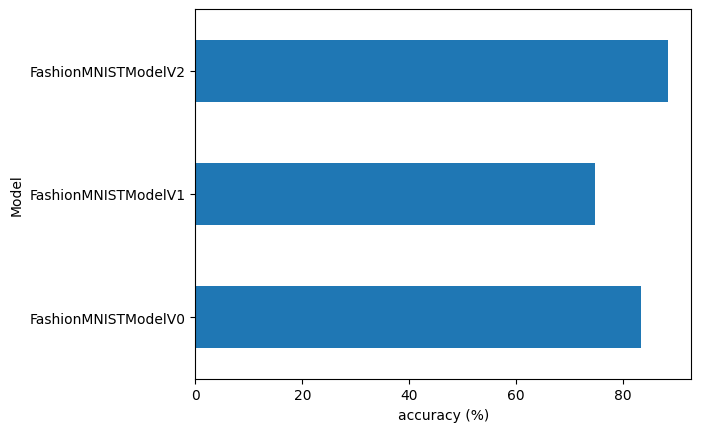

In [49]:
# Visualize the results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("Model")

# 8 Model 3: Variations on TinyVGG

* Increase size of layers
* Remove ReLU
* Other activation/optimizer functions

In [50]:
class FashionMNISTModelV3(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN Explainer website
    ReLU removed.
    """
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 num_classes: int):
        super(FashionMNISTModelV3, self).__init__()
        self.conv_blocks_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_blocks_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_size * int(28 / 4 * 28 / 4), out_features=num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks_1(x)
        x = self.conv_blocks_2(x)
        x = self.classifier(x)
        return x

In [51]:
torch.manual_seed(42)
model_3 = FashionMNISTModelV3(input_size=1, hidden_size=10, num_classes=len(train_data.classes)).to(device)

### 8.1 Setup a loss function and optimizer for CNN model

In [52]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)


### 8.2 Training and testing `model_3` using the training/test functions

It turns out that removing ReLU doesn't work for convolutional neural networks. ReLU is a non-linear activation function that allows CNNs to learn complex patterns in data. Without it, the model can't learn complex patterns.

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_3 = timer()

# Train and test the model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    ### Training
    train_loss, train_acc = train_step(model=model_3, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    print(f"\nTrain loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")

    ### Testing
    test_loss, test_acc = test_step(model=model_3, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

    # Print out whats happening
    print(f"Test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}%")

# Calculate total training time
train_time_end_model_3 = timer()
total_train_time_model_3 = print_train_time(train_time_start_model_3, train_time_end_model_3, device=str(next(model_3.parameters()).device))




  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------

Train loss: 0.4989, Train accuracy: 82.05%
Test loss: 0.37055, test accuracy: 86.70%
Epoch 2
-------------------------------

Train loss: 0.3436, Train accuracy: 87.66%
Test loss: 0.36261, test accuracy: 87.26%
Epoch 3
-------------------------------

Train loss: 0.3132, Train accuracy: 88.81%
Test loss: 0.33474, test accuracy: 88.08%
Time to train on mps:0: 30.069 seconds


### 8.3 Model 4: TinyVGG with bigger hidden layers

Let's see what going from 10 to 64 gains us.

In [54]:
torch.manual_seed(42)
model_4 = FashionMNISTModelV2(input_size=1, hidden_size=64, num_classes=len(train_data.classes)).to(device)

In [55]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_4 = timer()

# Train and test the model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    ### Training
    train_loss, train_acc = train_step(model=model_4, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)
    print(f"\nTrain loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")

    ### Testing
    test_loss, test_acc = test_step(model=model_4, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn)

    # Print out whats happening
    print(f"Test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}%")

# Calculate total training time
train_time_end_model_4 = timer()
total_train_time_model_4 = print_train_time(train_time_start_model_4, train_time_end_model_4, device=str(next(model_4.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------

Train loss: 0.4868, Train accuracy: 82.40%
Test loss: 0.33309, test accuracy: 88.06%
Epoch 2
-------------------------------

Train loss: 0.2946, Train accuracy: 89.41%
Test loss: 0.28742, test accuracy: 89.65%
Epoch 3
-------------------------------

Train loss: 0.2515, Train accuracy: 90.89%
Test loss: 0.26271, test accuracy: 90.63%
Time to train on mps:0: 67.686 seconds


In [57]:
# Evaluate the model
model_4_results = eval_model(model=model_4, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

model_4_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.26271072157417624,
 'model_acc': 90.6349840255591}

In [58]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results, model_4_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.690066,74.810304
2,FashionMNISTModelV2,0.327326,88.418530
3,FashionMNISTModelV2,0.262711,90.634984


Text(0, 0.5, 'Model')

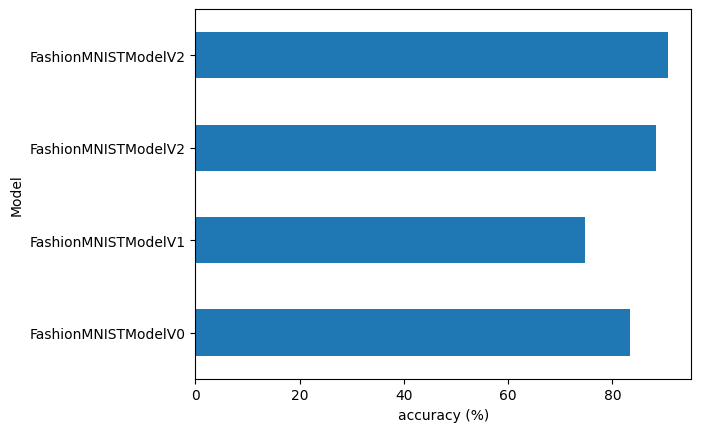

In [59]:
# Visualize the results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("Model")

# 9. Make and evaluate random predictions with best model

In [60]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device) -> list:
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X in data:
            X = torch.unsqueeze(X, dim=0).to(device) # because we need to add a batch dimension

            # Forward pass outputting raw logits
            pred_logits = model(X)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [61]:
import random
random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9) :
    test_samples.append(sample)
    test_labels.append(label)

Text(0.5, 1.0, 'Sandal')

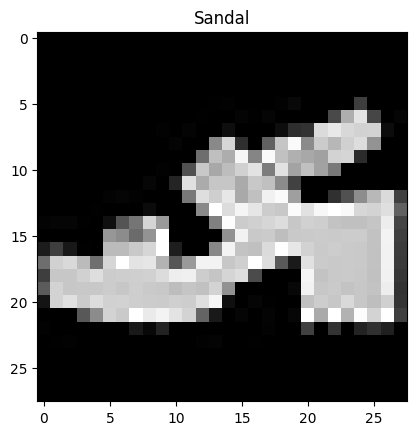

In [62]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(test_data.classes[test_labels[0]])

In [63]:
# Make predictions
pred_probs = make_predictions(model=model_2, data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.0743e-07, 4.3291e-08, 2.1373e-08, 5.1267e-08, 1.4701e-08, 9.9994e-01,
         8.6694e-08, 3.3358e-06, 2.3805e-05, 3.0043e-05],
        [6.9510e-02, 5.1804e-01, 1.9735e-03, 3.7161e-01, 6.9642e-03, 1.5109e-04,
         3.1194e-02, 3.2165e-04, 1.8130e-04, 5.7153e-05]])

In [64]:
# Convert prediction probabilities to predicted labels
pred_classes = pred_probs.argmax(dim=1) #[torch.argmax(pred_prob).item() for pred_prob in pred_probs]
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [65]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

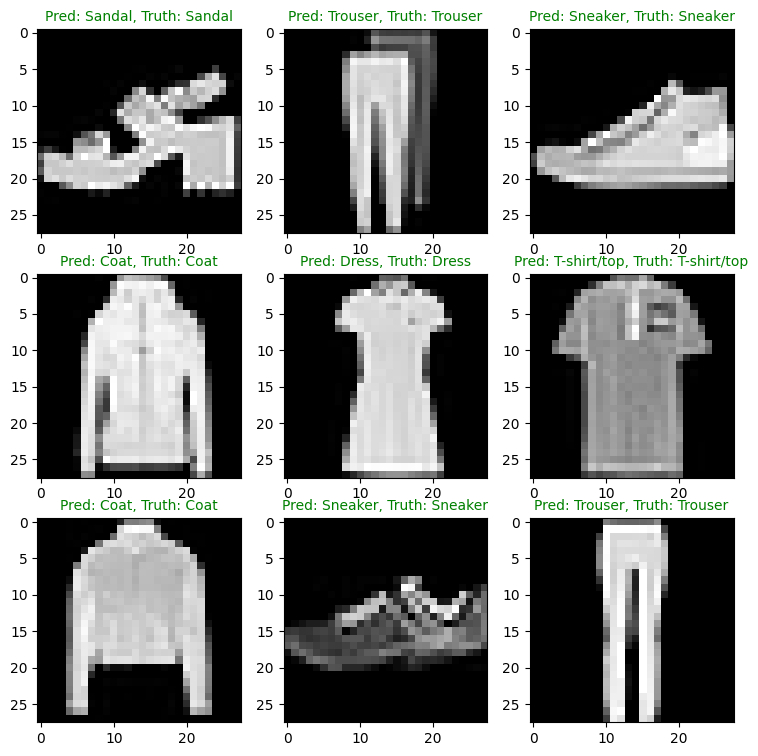

In [66]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form)
    pred_label = test_data.classes[pred_classes[i]]

    # Get the truth label (in text form)
    truth_label = test_data.classes[test_labels[i]]

    # Create the title
    title_text = f"Pred: {pred_label}, Truth: {truth_label}"

    # Check for equality between the prediction and truth
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, color="green")
    else:
        plt.title(title_text, fontsize=10, color="red")

# 10. Making a confusion matrix for further evaluation

A confusion matrix
https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics

1. Make predictions with our trained model on the test dataset
1. Make a confusion matrix
1. Plot the matrix with `mlextend`
1.  

Read:
https://sebastianraschka.com/books/


In [67]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

# Concatenate all the predictions
y_preds = torch.cat(y_preds)
y_preds[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [68]:
import torchmetrics

In [69]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend({mlxtend.__version__}) and torchmetrics already installed.")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher."
except:
    !pip install torchmetrics -U mlxtend
    import torchmetrics, mlxtend


mlxtend(0.23.2) and torchmetrics already installed.


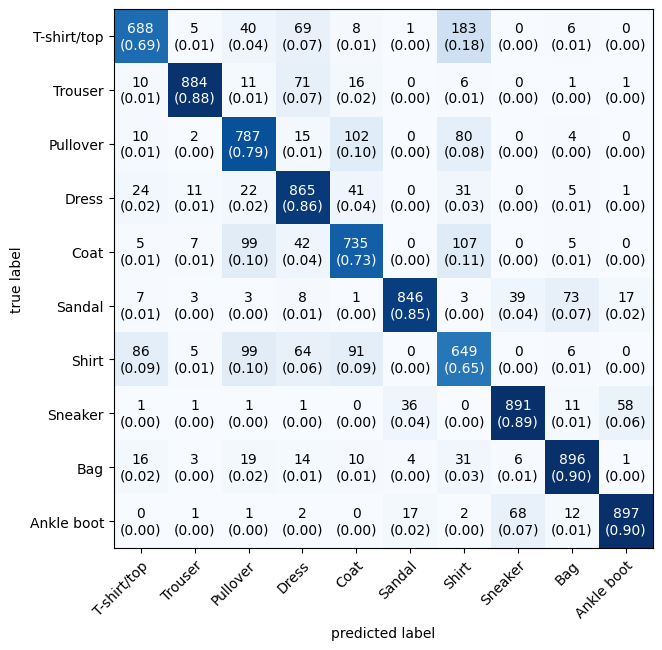

In [74]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance
conf_matrix = ConfusionMatrix(num_classes=len(test_data.classes), task="MULTICLASS") 
confmat_tensor = conf_matrix(preds=y_preds, target=test_data.targets)

# 3. Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy arrays
    figsize=(10, 7), 
    class_names=test_data.classes, 
    show_normed=True)

In [ ]:
confmat_tensor

# 11. Saving and loading a model

In [75]:
from pathlib import Path

MODEL_PATH =  Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_NAME = 'fashionmnist_model_v2.pth'
torch.save(model_2.state_dict(), MODEL_PATH / MODEL_SAVE_NAME)

In [77]:
loaded_model = FashionMNISTModelV2(input_size=1, hidden_size=10, num_classes=len(train_data.classes)).to(device)
loaded_model.load_state_dict(torch.load(MODEL_PATH / MODEL_SAVE_NAME, weights_only=True))

<All keys matched successfully>

In [78]:
# Evaluate the loaded model

torch.manual_seed(42)

loaded_model_results = eval_model(model=loaded_model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

loaded_model_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3273259679111429,
 'model_acc': 88.4185303514377}

In [79]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3273259679111429,
 'model_acc': 88.4185303514377}

In [83]:
# Checking if the loaded model is the same as the original model
torch.isclose(torch.tensor(model_2_results["model_loss"]), torch.tensor(loaded_model_results["model_loss"]), atol=1e-3), torch.isclose(torch.tensor(model_2_results["model_acc"]), torch.tensor(loaded_model_results["model_acc"]), atol=1e-3)

(tensor(True), tensor(True))